# Classify pulled tweets from twitter, for major US airlines.

In [1]:
cd '/home/jovyan/GA_DSI/Projects/capstone'

/home/jovyan/GA_DSI/Projects/capstone


In [2]:
#!pip install gensim

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import gensim
import re
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import string
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer
from spacy.en import English
nlp = English()

import lib.general_utilities as gu

from IPython.display import display
from IPython.display import Image
from sys import getsizeof
import matplotlib.pyplot as plt

processed_dir = 'data/processed_dataset_df/'
img_dir_out = 'data/images/Pulled_Tweets/'

%matplotlib inline


### NOTE: Tweets were pulled using filtering by #airlinename.

## Process pulled tweets by cleaning, removing stop words and lemmatizing.

In [4]:
# exclude name of airlines from the tweets. 
exclude = ['unitedairlines', 'americanairlines', 'southwestairlines',
           'virginamerica', 'usairways', 'jetblue', 'delta', 'flight', 'flights',
           'amp', 'amp;', 'rt', 'american', 'airline', 'southwest', 'united']

# load stopwords and exclude punctuation sets.
stop_words = list(ENGLISH_STOP_WORDS) + exclude
exclude_punctuation = set(string.punctuation) 
lemma = WordNetLemmatizer()

In [5]:
def tokenize(text):
    return(text.split())

In [6]:
def cleaner(text):
    # convert text to lowercase.
    text = text.lower()
    # remove www.* or https?://* 
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','',text)
    # remove @username 
    text = re.sub('@[^\s]+','',text)
    # remove additional white spaces
    text = re.sub('[\s]+', ' ', text)
    # Replace #word with word
    text = re.sub(r'#([^\s]+)', r'\1', text)
    # remove some punctuation symbols.
    text= ''.join(ch for ch in text if ch not in exclude_punctuation)
    # clean numbers.
    text = re.sub('[0-9]','',text).lower()
    # trim
    text = text.strip('\'"')
    # trim any leading or trailing white spaces.
    text = text.strip()

    return(text)

In [7]:
# remove stopwords.
def remove_stopwords(text):
    '''
    remove english stop words
    '''
    token_text = tokenize(text)
    text = ' '.join(i for i in token_text if (i.strip() not in stop_words))
    return(text)

In [8]:
def lemmatize(text):
    
    # lemmatize: replace word with root of the word.
    nlp_text = nlp(text)
    text = ' '.join(word.lemma_ for word in nlp_text if (word.lemma_ != '-PRON-'))
    
    return(text)

In [9]:
#!pip install emoji

In [10]:
import emoji

In [11]:
# read in pickled emoji dictionary I created from emojis in the dataset. I want to use
# each emoji as an individual feature.
file = 'data/pickled/Emoticon_NB4/full_emoji_dict.obj'
emoji_dict = gu.read_pickle_obj(file)

In [12]:
def encode_emojis(text):
    input_txt = text
    for em in text:
        if em in emoji.UNICODE_EMOJI:
            try:
                input_txt = input_txt.replace(em, emoji_dict[em])
            except:
                # update dict.
                cnt = len(emoji_dict.keys())
                cnt+=1
                val='EMOJI_'+str(cnt)
                emoji_dict[em]=val
                input_txt = input_txt.replace(em, val)
                
    return(input_txt)

In [13]:
def extract_emojis(text):
    return(' '.join(word for word in text if word in emoji.UNICODE_EMOJI))

In [14]:
def declump_emojis_in_text(text):
    em_txt = text        
    for i in text:
        if (i in emoji.UNICODE_EMOJI):
            em_txt = em_txt.replace(i,' '+i)
        
    return(em_txt)

### Read in pickled pulled tweets dataframe.

In [16]:
# Read in pulled tweets dataframe.
filename = 'data/pulled_tweets/PT_all_airlines_df'
pulledTweets_df = gu.read_pickle_obj(filename)

# Drop duplicate rows if any.
pulledTweets_df.drop_duplicates(subset='text', inplace=True)

pulledTweets_df.head(3)

,airline,date,text
0,UnitedAirlines,2018-01-09 21:19:36,Kudos to the #unitedairlines staff for helping...
1,UnitedAirlines,2018-01-09 21:06:39,And the painful experience with @united conti...
2,UnitedAirlines,2018-01-09 21:02:07,@united is the shittiest airline company I hav...


In [17]:
pulledTweets_df.columns

Index(['airline', 'date', 'text'], dtype='object')

### Process tweets.

In [18]:
# Process data using Natural Language Processing techniques: clean, remove stop words and lemmatize.

# Clean tweet of web tags and punctuations.
pulledTweets_df['clean_tweet'] = pulledTweets_df['text'].apply(cleaner)

# Encode emojis.
# right now ☺️👍 will be a feature. I want features independent 
# as ☺️ and 👍. Let's declump them.
pulledTweets_df['emoji_enc_tweet'] = pulledTweets_df['clean_tweet'].apply(declump_emojis_in_text)
# Now let's encode the emojis so we can use it in the vectorizer as a feature.
pulledTweets_df['emoji_enc_tweet'] = pulledTweets_df['emoji_enc_tweet'].apply(encode_emojis)

# Remove stop words.
pulledTweets_df['remstop_tweet'] = pulledTweets_df['emoji_enc_tweet'].apply(remove_stopwords)

# Lemmatize. (Remove redundancy - data dimensionality reduction)
pulledTweets_df['lemma_tweet'] = pulledTweets_df['remstop_tweet'].apply(lemmatize)

# create a new category 'emojis' with extracted emojis from tweets.
pulledTweets_df['emojis'] = pulledTweets_df['clean_tweet'].apply(extract_emojis)

In [19]:
pulledTweets_df.head(20)

,airline,date,text,clean_tweet,emoji_enc_tweet,remstop_tweet,lemma_tweet,emojis
0,UnitedAirlines,2018-01-09 21:19:36,Kudos to the #unitedairlines staff for helping...,kudos to the unitedairlines staff for helping ...,kudos to the unitedairlines staff for helping ...,kudos staff helping crazy reservations nice se...,kudo staff help crazy reservation nice sendoff...,
1,UnitedAirlines,2018-01-09 21:06:39,And the painful experience with @united conti...,and the painful experience with continues as t...,and the painful experience with continues as t...,painful experience continues ask time lengthy ...,painful experience continue ask time lengthy r...,
2,UnitedAirlines,2018-01-09 21:02:07,@united is the shittiest airline company I hav...,is the shittiest airline company i have ever e...,is the shittiest airline company i have ever e...,shittiest company experienced fuck neveragain ...,shitti company experience fuck neveragain lies...,
3,UnitedAirlines,2018-01-09 20:56:00,Oh joy. You came home. #lostluggage #unitedair...,oh joy you came home lostluggage unitedairlines,oh joy you came home lostluggage unitedairlines,oh joy came home lostluggage,oh joy come home lostluggage,
4,UnitedAirlines,2018-01-09 20:49:48,RT @officiParas: #UnitedAirlines Offers Custom...,rt unitedairlines offers customers two free ch...,rt unitedairlines offers customers two free ch...,offers customers free checked bags travel tofr...,offer customer free check bag travel tofrom ch...,
5,UnitedAirlines,2018-01-09 20:41:02,#UnitedAirlines - still can’t understand why a...,unitedairlines still can’t understand why as ...,unitedairlines still can’t understand why as ...,can’t understand million miler mm board grp no...,can not understand million miler mm board grp ...,
6,UnitedAirlines,2018-01-09 20:33:20,My knees #unitedAIRLINES https://t.co/qErdox2Cht,my knees unitedairlines,my knees unitedairlines,knees,knee,
7,UnitedAirlines,2018-01-09 20:24:22,@theweeknd cuts ties with H&amp;M over 'monkey...,cuts ties with hampm over monkey ad blm equali...,cuts ties with hampm over monkey ad blm equali...,cuts ties hampm monkey ad blm equalityall monk...,cut tie hampm monkey ad blm equalityall monkey...,
8,UnitedAirlines,2018-01-09 20:15:15,"A peek inside Classified, where CEOs and celeb...",a peek inside classified where ceos and celebr...,a peek inside classified where ceos and celebr...,peek inside classified ceos celebrities dine h...,peek inside classified ceo celebrity dine hidd...,
9,UnitedAirlines,2018-01-09 19:48:04,"Montreal, Canada to Phoenix, Arizona for only ...",montreal canada to phoenix arizona for only c...,montreal canada to phoenix arizona for only c...,montreal canada phoenix arizona cad roundtrip ...,montreal canada phoenix arizona cad roundtrip ...,


In [263]:
for row in range(100,106):
    print('Tweet: ')
    # Some tweets have \n - newlines, remove so it displays well.
    text = pulledTweets_df.text[pulledTweets_df.emojis!=''].values[row]
    text = text.replace('\n','')
    print('RAW TWEET: ', text, '\n')
    print('CLEAN TWEET: ', pulledTweets_df.clean_tweet[pulledTweets_df.emojis!=''].values[row], '\n')
    print('EMOJI ENC TWEET: ', pulledTweets_df.emoji_enc_tweet[pulledTweets_df.emojis!=''].values[row], '\n')
    print('REM STOPW TWEET: ', pulledTweets_df.remstop_tweet[pulledTweets_df.emojis!=''].values[row], '\n')
    print('LEMMA TWEET: ', pulledTweets_df.lemma_tweet[pulledTweets_df.emojis!=''].values[row], '\n------\n')
    

Tweet: 
RAW TWEET:  From https://t.co/vIwrgN5xSaReady to go.. ✈️😍💯 #AmericanAirlines #Thenewamerican #B737 #intheair #americanflight #aa #flights #saturday #intapic #instaimag #photooftheday #likes #zoom #crew #pilots #crewamerican #honduras #hn #aiport #iphonecamera #newphoto #inlove #newcap… https://t.co/BhaD0tVyKC 

CLEAN TWEET:  from ready to go ✈️😍💯 americanairlines thenewamerican b intheair americanflight aa flights saturday intapic instaimag photooftheday likes zoom crew pilots crewamerican honduras hn aiport iphonecamera newphoto inlove newcap… 

EMOJI ENC TWEET:  from ready to go  EMOJI_7️ EMOJI_11 EMOJI_90 americanairlines thenewamerican b intheair americanflight aa flights saturday intapic instaimag photooftheday likes zoom crew pilots crewamerican honduras hn aiport iphonecamera newphoto inlove newcap… 

REM STOPW TWEET:  ready EMOJI_7️ EMOJI_11 EMOJI_90 thenewamerican b intheair americanflight aa saturday intapic instaimag photooftheday likes zoom crew pilots crewamerican 

### Pickle processed pulled tweets.

In [20]:
# Update emoji dict. Eventually unicode-escape this.
file = 'data/pickled/Emoticon_NB4/full_emoji_dict.obj'
gu.pickle_obj(file, emoji_dict)

In [21]:
# pickle pulled data.
filename = processed_dir+'pulledTweetsCleanedLemmaEmEnc_df'
gu.pickle_obj(filename,pulledTweets_df)

### Use best grid searched Naive Bayes and Logistic Regression models to classify tweets.

In [22]:
# Read the gridsearch results dataframe.
data_dir = 'data/pickled/Modelling_NB3_70PercConf_withEmojiEncoding/GridSearch/'
EmEnc_model_results_gs_df = gu.read_pickle_obj(data_dir+'benchmark_model_results_df')

In [33]:
EmEnc_model_results_gs_df

,dataset,model,tr_acc_score,tst_acc_score,pipe_object,y_pred,ytest,ypred_proba
0,clean text,NaiveBayes,0.926167,0.868617,"GridSearchCV(cv=5, error_score='raise',\n ...","[1, 1, 2, 0, 1, 0, 0, 2, 0, 0, 0, 1, 2, 2, 0, ...","[1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...","[[2.02843744554e-08, 0.999999960244, 1.9471643..."
1,clean text,LogisticRegression,0.977943,0.882544,"GridSearchCV(cv=5, error_score='raise',\n ...","[1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 2, 1, 2, 0, 0, ...","[1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...","[[0.0524762645603, 0.945196567423, 0.002327168..."
2,remove stopwords,NaiveBayes,0.872765,0.833333,"GridSearchCV(cv=5, error_score='raise',\n ...","[1, 0, 2, 0, 1, 0, 0, 2, 0, 0, 0, 1, 2, 0, 0, ...","[1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...","[[0.11063421503, 0.729171649849, 0.16019413512..."
3,remove stopwords,LogisticRegression,0.921291,0.847725,"GridSearchCV(cv=5, error_score='raise',\n ...","[1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 2, 1, 2, 0, 0, ...","[1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...","[[0.224446040854, 0.728331158498, 0.0472228006..."
4,applied stemming,NaiveBayes,0.868470,0.831476,"GridSearchCV(cv=5, error_score='raise',\n ...","[1, 0, 2, 0, 0, 0, 0, 2, 0, 0, 2, 1, 2, 2, 0, ...","[1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...","[[0.0950630951518, 0.74397991148, 0.1609569933..."
5,applied stemming,LogisticRegression,0.920710,0.854225,"GridSearchCV(cv=5, error_score='raise',\n ...","[1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 2, 1, 2, 2, 0, ...","[1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...","[[0.132076467466, 0.800913640073, 0.0670098924..."
6,lemmatized,NaiveBayes,0.866729,0.831941,"GridSearchCV(cv=5, error_score='raise',\n ...","[1, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 0, 0, ...","[1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...","[[0.0861210441938, 0.734018225832, 0.179860729..."
7,lemmatized,LogisticRegression,0.921059,0.848189,"GridSearchCV(cv=5, error_score='raise',\n ...","[1, 1, 1, 0, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 0, ...","[1, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2, 0, ...","[[0.125866022242, 0.805345237361, 0.0687887403..."


### To classify data I will use the grid searched Naive Bayes and Logistic Regression models.

In [34]:
pipe_nb  =EmEnc_model_results_gs_df.get_value(0, 'pipe_object')
pipe_lr = EmEnc_model_results_gs_df.get_value(1, 'pipe_object')

# pickle models.
file1 = processed_dir+'pipe_nb_lemma.obj'
file2 = processed_dir+'pipe_lr_lemma.obj'
gu.pickle_obj(file1, pipe_nb)
gu.pickle_obj(file2, pipe_lr)

In [35]:
pipe_nb.best_params_, pipe_lr.best_params_

({'model__alpha': 0.10000000000000001,
  'vec__max_df': 0.95,
  'vec__min_df': 5,
  'vec__ngram_range': (1, 2)},
 {'model__C': 1.0,
  'vec__max_df': 0.95,
  'vec__min_df': 5,
  'vec__ngram_range': (1, 2)})

In [36]:
classes = {0:'negative', 1:'neutral', 2:'positive'}

In [37]:
# Naive Bayes
y_pred = pipe_nb.predict(pulledTweets_df.clean_tweet)
y_proba = pipe_nb.predict_proba(pulledTweets_df.clean_tweet)

pulledTweets_df['sentiment_predicted_nb']=[classes[y_pred[i]] for i in range(len(y_pred))]

In [38]:
# Logistic Regression.
y_pred = pipe_lr.predict(pulledTweets_df.clean_tweet)
y_proba = pipe_lr.predict_proba(pulledTweets_df.clean_tweet)

pulledTweets_df['sentiment_predicted_lr']=[classes[y_pred[i]] for i in range(len(y_pred))]

In [39]:
pulledTweets_df[['text', 'sentiment_predicted_nb', 'sentiment_predicted_lr', 'emojis']][:20]

,text,sentiment_predicted_nb,sentiment_predicted_lr,emojis
0,Kudos to the #unitedairlines staff for helping...,positive,positive,
1,And the painful experience with @united conti...,negative,negative,
2,@united is the shittiest airline company I hav...,negative,negative,
3,Oh joy. You came home. #lostluggage #unitedair...,negative,negative,
4,RT @officiParas: #UnitedAirlines Offers Custom...,negative,negative,
5,#UnitedAirlines - still can’t understand why a...,negative,negative,
6,My knees #unitedAIRLINES https://t.co/qErdox2Cht,negative,negative,
7,@theweeknd cuts ties with H&amp;M over 'monkey...,negative,negative,
8,"A peek inside Classified, where CEOs and celeb...",neutral,neutral,
9,"Montreal, Canada to Phoenix, Arizona for only ...",negative,neutral,


### Pickle dataframe with processed and classified tweets.

In [40]:
# pickle classified data.
filename = processed_dir+'pulledTweetsProcessedAndClassified_df'
gu.pickle_obj(filename,pulledTweets_df)

In [3]:
# read pickled data.
pulledTweets_df = gu.read_pickle_obj(processed_dir+'pulledTweetsProcessedAndClassified_df')

In [4]:
pulledTweets_df.head(2)

,airline,date,text,clean_tweet,emoji_enc_tweet,remstop_tweet,lemma_tweet,emojis,sentiment_predicted_nb,sentiment_predicted_lr
0,UnitedAirlines,2018-01-09 21:19:36,Kudos to the #unitedairlines staff for helping...,kudos to the unitedairlines staff for helping ...,kudos to the unitedairlines staff for helping ...,kudos staff helping crazy reservations nice se...,kudo staff help crazy reservation nice sendoff...,,positive,positive
1,UnitedAirlines,2018-01-09 21:06:39,And the painful experience with @united conti...,and the painful experience with continues as t...,and the painful experience with continues as t...,painful experience continues ask time lengthy ...,painful experience continue ask time lengthy r...,,negative,negative


### Let's visualize the predictions for both models.

In [43]:
pulledTweets_df.airline.value_counts()

Delta                2119
AmericanAirlines     1013
UnitedAirlines        792
SouthWestAirlines     767
JetBlue               590
VirginAmerica          41
USAirways               3
Name: airline, dtype: int64

In [44]:
d_air = pulledTweets_df[pulledTweets_df.airline == 'Delta']

In [45]:
d_air.shape, d_air.sentiment_predicted_lr.value_counts()

((2119, 10), negative    1521
 neutral      464
 positive     134
 Name: sentiment_predicted_lr, dtype: int64)

In [46]:
percent_neg = d_air.sentiment_predicted_lr.value_counts()[0]/d_air.shape[0]
percent_neut = d_air.sentiment_predicted_lr.value_counts()[1]/d_air.shape[0]
percent_pos = d_air.sentiment_predicted_lr.value_counts()[2]/d_air.shape[0]

In [47]:
percent_neg,percent_neut,percent_pos

(0.71779141104294475, 0.21897121283624352, 0.063237376120811706)

In [10]:
pulledTweets_df = pulledTweets_df[pulledTweets_df.airline != 'USAirways']

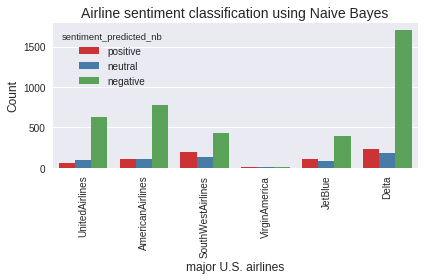

In [11]:
# Airline sentiment using Naive Bayes.
sns.countplot(x="airline", hue="sentiment_predicted_nb", 
              data = pulledTweets_df, hue_order=['positive', 'neutral', 'negative'],
              palette = 'Set1')
plt.title('Airline sentiment classification using Naive Bayes',
         fontsize=14)
plt.xlabel('major U.S. airlines', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.savefig('data/images/Pulled_Tweets/'+'NB_sentiment_classification_hist.png')

In [ ]:
# Countplot plots the counts of values.
# I want to display the percentage of negative, neutral and positive tweets, for each airline.

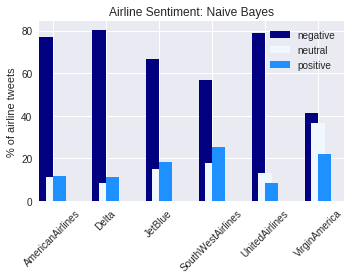

In [15]:
# Create mask to group airlines by sentiment, to find value counts.
mask_neg = pulledTweets_df['airline'][pulledTweets_df.sentiment_predicted_nb=='negative']
mask_neut = pulledTweets_df['airline'][pulledTweets_df.sentiment_predicted_nb=='neutral']
mask_pos = pulledTweets_df['airline'][pulledTweets_df.sentiment_predicted_nb=='positive']

airline_tweet_totals = pulledTweets_df.airline.value_counts()
neg = mask_neg.value_counts(); neut = mask_neut.value_counts(); pos = mask_pos.value_counts()

# Now sort the index so all sentiment series have same airline order.
neg.sort_index(inplace=True); pos.sort_index(inplace=True); 
neut.sort_index(inplace=True); airline_tweet_totals.sort_index(inplace=True);

# Display y-axis as percentage. 
perc_neg = (neg/airline_tweet_totals)*100
perc_pos = (pos/airline_tweet_totals)*100
perc_neut = (neut/airline_tweet_totals)*100

width=0.25
plt.figure(figsize=(5,4))
perc_neg.plot(kind='bar', color='navy', width=width, position=1, title='Airline Sentiment')
perc_neut.plot(kind='bar', color='aliceblue', width= width, position=0.5, title='Airline Sentiment')
perc_pos.plot(kind='bar', color='dodgerblue', width=width, position=0, title='Airline Sentiment: Naive Bayes')
plt.legend(('negative', 'neutral', 'positive'), loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)
plt.ylabel('% of airline tweets')
plt.tight_layout()

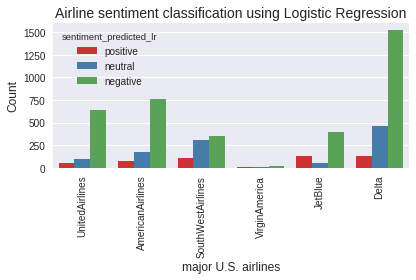

In [20]:
# Airline sentiment using Logistic Regression.
sns.countplot(x="airline", hue="sentiment_predicted_lr", data=df, 
              hue_order=['positive', 'neutral', 'negative'], palette = 'Set1')
plt.title('Airline sentiment classification using Logistic Regression',
         fontsize=14)
plt.xlabel('major U.S. airlines', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('data/images/Pulled_Tweets/'+'LR_sentiment_classification_hist.png')

In [ ]:
# Countplot plots the counts of values.
# I want to display the percentage of negatie, neutral and positive tweets, for each airline.

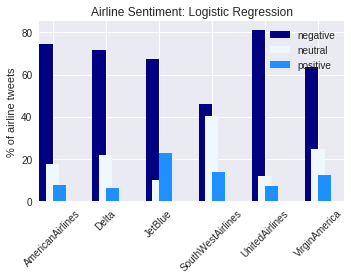

In [19]:
# Create mask to group airlines by sentiment, to find value counts.
mask_neg = pulledTweets_df['airline'][pulledTweets_df.sentiment_predicted_lr=='negative']
mask_neut = pulledTweets_df['airline'][pulledTweets_df.sentiment_predicted_lr=='neutral']
mask_pos = pulledTweets_df['airline'][pulledTweets_df.sentiment_predicted_lr=='positive']

airline_tweet_totals = pulledTweets_df.airline.value_counts()
neg = mask_neg.value_counts(); neut = mask_neut.value_counts(); pos = mask_pos.value_counts()

# Now sort the index so all sentiment series have same airline order.
neg.sort_index(inplace=True); pos.sort_index(inplace=True); 
neut.sort_index(inplace=True); airline_tweet_totals.sort_index(inplace=True);

# Display y-axis as percentage. 
perc_neg = (neg/airline_tweet_totals)*100
perc_pos = (pos/airline_tweet_totals)*100
perc_neut = (neut/airline_tweet_totals)*100

width=0.25
plt.figure(figsize=(5,4))
perc_neg.plot(kind='bar', color='navy', width=width, position=1, title='Airline Sentiment')
perc_neut.plot(kind='bar', color='aliceblue', width= width, position=0.5, title='Airline Sentiment')
perc_pos.plot(kind='bar', color='dodgerblue', width=width, position=0, 
              title='Airline Sentiment: Logistic Regression')
plt.legend(('negative', 'neutral', 'positive'), loc='upper right')
plt.grid(True)
plt.xticks(rotation=45)
plt.ylabel('% of airline tweets')
plt.tight_layout()

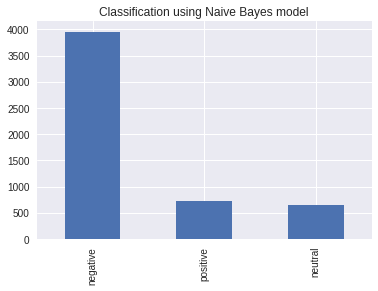

In [51]:
# look at the count of values for the 3 categories.
pulledTweets_df.sentiment_predicted_nb.value_counts().plot(kind='bar', 
                                                           title = 'Classification using Naive Bayes model')
plt.savefig('data/images/Pulled_Tweets/'+'NB_class_hist.png')

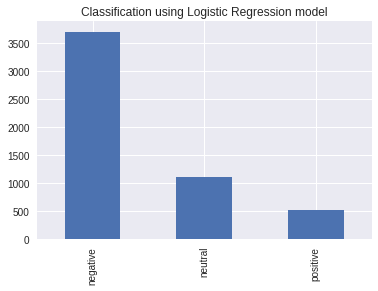

In [52]:
# look at the count of values for the 3 categories.
pulledTweets_df.sentiment_predicted_lr.value_counts().plot(kind='bar', 
                                                           title = 'Classification using Logistic Regression model')
plt.savefig('data/images/Pulled_Tweets/'+'LR_class_hist.png')

In [53]:
for i in range(100):
    print('TWEET:\n', pulledTweets_df.date.values[i], '\n', pulledTweets_df.text.values[i], 
          '\n\nSentiment Prediction NB:\n', pulledTweets_df.sentiment_predicted_nb.values[i],
          '\nSentiment Prediction LR:\n', pulledTweets_df.sentiment_predicted_lr.values[i],
          '\n')

TWEET:
 2018-01-09T21:19:36.000000000 
 Kudos to the #unitedairlines staff for helping us with our crazy reservations.  Nice send-off from CHS 

Sentiment Prediction NB:
 positive 
Sentiment Prediction LR:
 positive 

TWEET:
 2018-01-09T21:06:39.000000000 
 And the painful experience with  @united continues as they ask us to take the time to fill out lengthy reports on their website and to relive the blissful experience again. Thanks for nothing #unitedairlines ! https://t.co/W9skVmOhZw 

Sentiment Prediction NB:
 negative 
Sentiment Prediction LR:
 negative 

TWEET:
 2018-01-09T21:02:07.000000000 
 @united is the shittiest airline company I have ever experienced. Fuck #UnitedAirlines #neveragain #lieslieslies 

Sentiment Prediction NB:
 negative 
Sentiment Prediction LR:
 negative 

TWEET:
 2018-01-09T20:56:00.000000000 
 Oh joy. You came home. #lostluggage #unitedairlines https://t.co/msJgTAjiz6 https://t.co/8fHuZntw7e 

Sentiment Prediction NB:
 negative 
Sentiment Prediction LR:
 n

## Look at top ngrams of different class' tweets, to see if topics can be identified.

In [54]:
df_senti = pulledTweets_df[['airline', 'lemma_tweet', 'sentiment_predicted_nb', 'sentiment_predicted_lr']]
df_senti.head()

,airline,lemma_tweet,sentiment_predicted_nb,sentiment_predicted_lr
0,UnitedAirlines,kudo staff help crazy reservation nice sendoff...,positive,positive
1,UnitedAirlines,painful experience continue ask time lengthy r...,negative,negative
2,UnitedAirlines,shitti company experience fuck neveragain lies...,negative,negative
3,UnitedAirlines,oh joy come home lostluggage,negative,negative
4,UnitedAirlines,offer customer free check bag travel tofrom ch...,negative,negative


In [55]:
print(emoji_dict)

{'❤': 'EMOJI_1', '☺': 'EMOJI_2', '👍': 'EMOJI_3', '😡': 'EMOJI_4', '😢': 'EMOJI_5', '💜': 'EMOJI_6', '✈': 'EMOJI_7', '🍷': 'EMOJI_8', '💺': 'EMOJI_9', '😊': 'EMOJI_10', '😍': 'EMOJI_11', '👌': 'EMOJI_12', '💕': 'EMOJI_13', '🌞': 'EMOJI_14', '😃': 'EMOJI_15', '😩': 'EMOJI_16', '😭': 'EMOJI_17', '😎': 'EMOJI_18', '🙉': 'EMOJI_19', '😁': 'EMOJI_20', '❄': 'EMOJI_21', '👏': 'EMOJI_22', '😂': 'EMOJI_23', '💗': 'EMOJI_24', '🍸': 'EMOJI_25', '😒': 'EMOJI_26', '👎': 'EMOJI_27', '😀': 'EMOJI_28', '😄': 'EMOJI_29', '😘': 'EMOJI_30', '👸': 'EMOJI_31', '🎀': 'EMOJI_32', '🌏': 'EMOJI_33', '😥': 'EMOJI_34', '😉': 'EMOJI_35', '✨': 'EMOJI_36', '😱': 'EMOJI_37', '🎉': 'EMOJI_38', '🙌': 'EMOJI_39', '💤': 'EMOJI_40', '😞': 'EMOJI_41', '♥': 'EMOJI_42', '👋': 'EMOJI_43', '✌': 'EMOJI_44', '🙏': 'EMOJI_45', '👿': 'EMOJI_46', '😔': 'EMOJI_47', '🙅': 'EMOJI_48', '🆖': 'EMOJI_49', '💩': 'EMOJI_50', '✔': 'EMOJI_51', '🌴': 'EMOJI_52', '✅': 'EMOJI_53', '❌': 'EMOJI_54', '👠': 'EMOJI_55', '😜': 'EMOJI_56', '😻': 'EMOJI_57', '😕': 'EMOJI_58', '😈': 'EMOJI_59', '😤': 

In [85]:
def disp_top_grams(words_df, model_name, sentiment, NumTopGrams, airline, ngrams):

    words_sorted_ordimp = words_df[words_df.index == sentiment].\
                                                    sum().sort_values(ascending=False)
    words_sorted_ordimp.head(NumTopGrams).plot(kind='barh', 
                                               title='Airline: '+airline+' Model: '+model_name+' Sentiment: '+sentiment, 
                                               figsize=(6,6),
                                               fontsize=12)
    plt.grid(False)
    plt.tight_layout()
    plt.savefig(img_dir_out+
                'top_'+str(ngrams)+
                '_grams_'+
                model_name+
                '_'+airline+
                '_'+sentiment+
                '.png')
    plt.show()
    # print top 30 features.
    print(words_sorted_ordimp[:NumTopGrams].index)

In [83]:
def disp_top_gram_topics(numGrams, target, model_name, NumTopGrams, sentiment, airline):
    
    cv = CountVectorizer(ngram_range=(numGrams,numGrams), max_df=95, min_df=5)
    X_cv = cv.fit_transform(df_senti['lemma_tweet'][df_senti.airline==airline])

    words_df = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names())
    words_df.index = target
    
    disp_top_grams(words_df, model_name, sentiment, NumTopGrams, airline, numGrams)

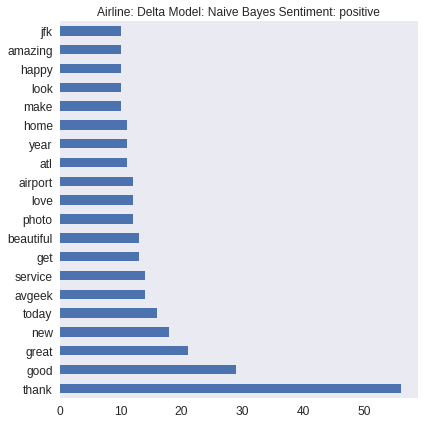

Index(['thank', 'good', 'great', 'new', 'today', 'avgeek', 'service', 'get',
       'beautiful', 'photo', 'love', 'airport', 'atl', 'year', 'home', 'make',
       'look', 'happy', 'amazing', 'jfk'],
      dtype='object')


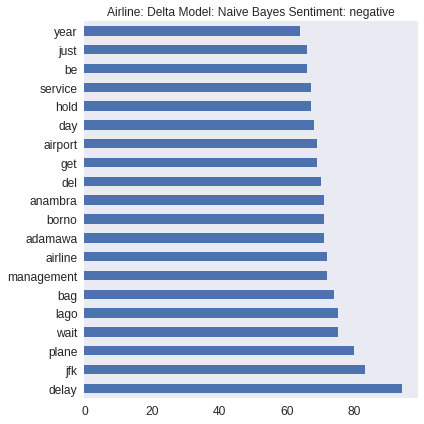

Index(['delay', 'jfk', 'plane', 'wait', 'lago', 'bag', 'management', 'airline',
       'adamawa', 'borno', 'anambra', 'del', 'get', 'airport', 'day', 'hold',
       'service', 'be', 'just', 'year'],
      dtype='object')


In [86]:
numGrams = 1
NumTopGrams = 20
airline = 'Delta'

target = df_senti['sentiment_predicted_nb'][df_senti.airline==airline]
model_name = 'Naive Bayes'
disp_top_gram_topics(numGrams, target, model_name, NumTopGrams, 'positive', airline)
disp_top_gram_topics(numGrams, target, model_name, NumTopGrams, 'negative', airline)


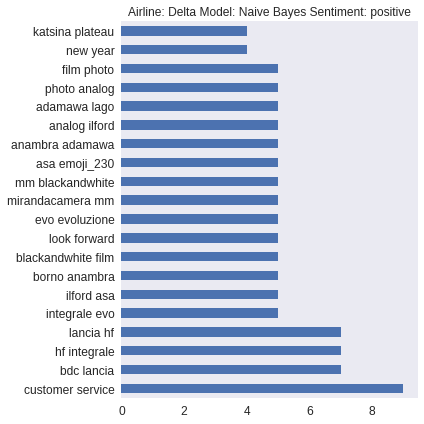

Index(['customer service', 'bdc lancia', 'hf integrale', 'lancia hf',
       'integrale evo', 'ilford asa', 'borno anambra', 'blackandwhite film',
       'look forward', 'evo evoluzione', 'mirandacamera mm',
       'mm blackandwhite', 'asa emoji_230', 'anambra adamawa', 'analog ilford',
       'adamawa lago', 'photo analog', 'film photo', 'new year',
       'katsina plateau'],
      dtype='object')


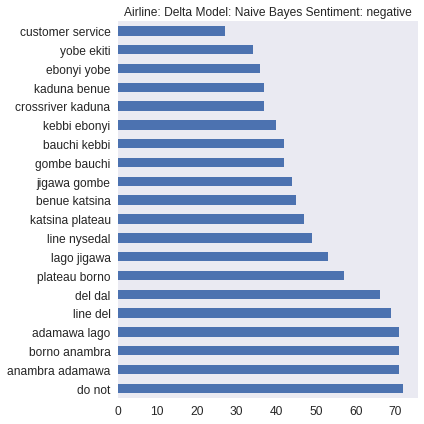

Index(['do not', 'anambra adamawa', 'borno anambra', 'adamawa lago',
       'line del', 'del dal', 'plateau borno', 'lago jigawa', 'line nysedal',
       'katsina plateau', 'benue katsina', 'jigawa gombe', 'gombe bauchi',
       'bauchi kebbi', 'kebbi ebonyi', 'crossriver kaduna', 'kaduna benue',
       'ebonyi yobe', 'yobe ekiti', 'customer service'],
      dtype='object')


In [87]:
numGrams = 2
NumTopGrams = 20
airline = 'Delta'

target = df_senti['sentiment_predicted_nb'][df_senti.airline==airline]
model_name = 'Naive Bayes'
disp_top_gram_topics(numGrams, target, model_name, NumTopGrams, 'positive', airline)
disp_top_gram_topics(numGrams, target, model_name, NumTopGrams, 'negative', airline)


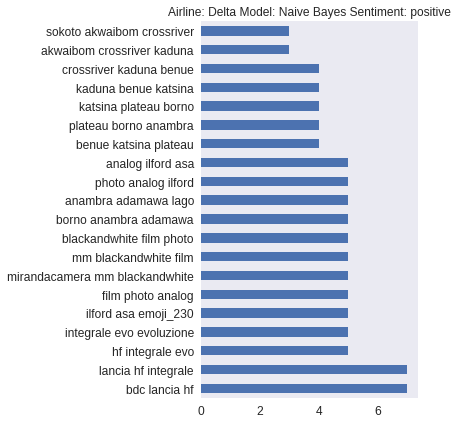

Index(['bdc lancia hf', 'lancia hf integrale', 'hf integrale evo',
       'integrale evo evoluzione', 'ilford asa emoji_230', 'film photo analog',
       'mirandacamera mm blackandwhite', 'mm blackandwhite film',
       'blackandwhite film photo', 'borno anambra adamawa',
       'anambra adamawa lago', 'photo analog ilford', 'analog ilford asa',
       'benue katsina plateau', 'plateau borno anambra',
       'katsina plateau borno', 'kaduna benue katsina',
       'crossriver kaduna benue', 'akwaibom crossriver kaduna',
       'sokoto akwaibom crossriver'],
      dtype='object')


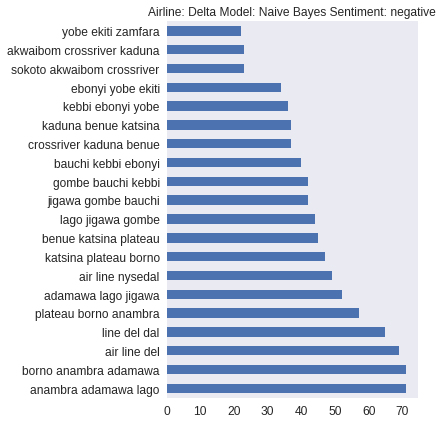

Index(['anambra adamawa lago', 'borno anambra adamawa', 'air line del',
       'line del dal', 'plateau borno anambra', 'adamawa lago jigawa',
       'air line nysedal', 'katsina plateau borno', 'benue katsina plateau',
       'lago jigawa gombe', 'jigawa gombe bauchi', 'gombe bauchi kebbi',
       'bauchi kebbi ebonyi', 'crossriver kaduna benue',
       'kaduna benue katsina', 'kebbi ebonyi yobe', 'ebonyi yobe ekiti',
       'sokoto akwaibom crossriver', 'akwaibom crossriver kaduna',
       'yobe ekiti zamfara'],
      dtype='object')


In [88]:
numGrams = 3
NumTopGrams = 20
airline = 'Delta'

target = df_senti['sentiment_predicted_nb'][df_senti.airline==airline]
model_name = 'Naive Bayes'
disp_top_gram_topics(numGrams, target, model_name, NumTopGrams, 'positive', airline)
disp_top_gram_topics(numGrams, target, model_name, NumTopGrams, 'negative', airline)

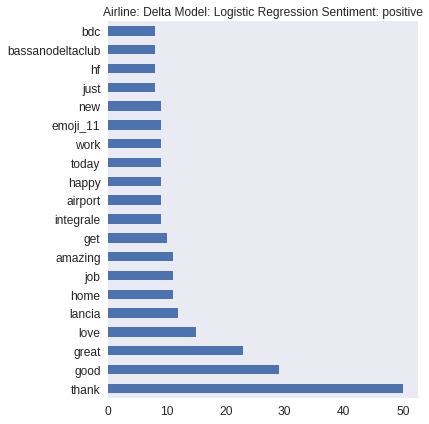

Index(['thank', 'good', 'great', 'love', 'lancia', 'home', 'job', 'amazing',
       'get', 'integrale', 'airport', 'happy', 'today', 'work', 'emoji_11',
       'new', 'just', 'hf', 'bassanodeltaclub', 'bdc'],
      dtype='object')


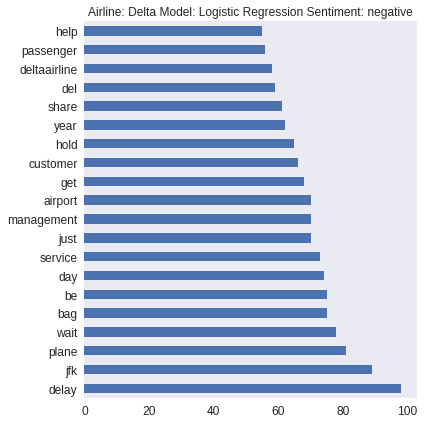

Index(['delay', 'jfk', 'plane', 'wait', 'bag', 'be', 'day', 'service', 'just',
       'management', 'airport', 'get', 'customer', 'hold', 'year', 'share',
       'del', 'deltaairline', 'passenger', 'help'],
      dtype='object')


In [89]:
numGrams = 1
NumTopGrams = 20
airline = 'Delta'

target = df_senti['sentiment_predicted_lr'][df_senti.airline==airline]
model_name = 'Logistic Regression'
disp_top_gram_topics(numGrams, target, model_name, NumTopGrams, 'positive', airline)
disp_top_gram_topics(numGrams, target, model_name, NumTopGrams, 'negative', airline)


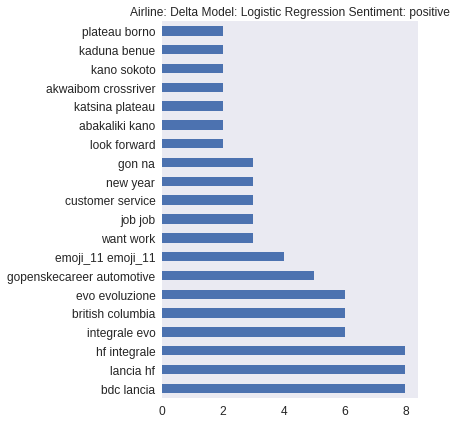

Index(['bdc lancia', 'lancia hf', 'hf integrale', 'integrale evo',
       'british columbia', 'evo evoluzione', 'gopenskecareer automotive',
       'emoji_11 emoji_11', 'want work', 'job job', 'customer service',
       'new year', 'gon na', 'look forward', 'abakaliki kano',
       'katsina plateau', 'akwaibom crossriver', 'kano sokoto', 'kaduna benue',
       'plateau borno'],
      dtype='object')


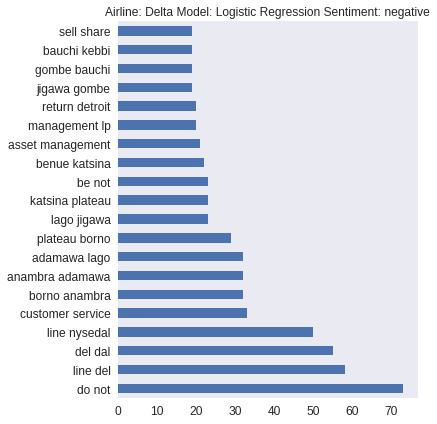

Index(['do not', 'line del', 'del dal', 'line nysedal', 'customer service',
       'borno anambra', 'anambra adamawa', 'adamawa lago', 'plateau borno',
       'lago jigawa', 'katsina plateau', 'be not', 'benue katsina',
       'asset management', 'management lp', 'return detroit', 'jigawa gombe',
       'gombe bauchi', 'bauchi kebbi', 'sell share'],
      dtype='object')


In [90]:
numGrams = 2
NumTopGrams = 20
airline = 'Delta'

target = df_senti['sentiment_predicted_lr'][df_senti.airline==airline]
model_name = 'Logistic Regression'
disp_top_gram_topics(numGrams, target, model_name, NumTopGrams, 'positive', airline)
disp_top_gram_topics(numGrams, target, model_name, NumTopGrams, 'negative', airline)

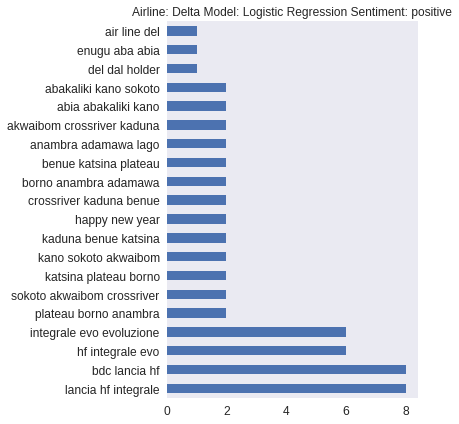

Index(['lancia hf integrale', 'bdc lancia hf', 'hf integrale evo',
       'integrale evo evoluzione', 'plateau borno anambra',
       'sokoto akwaibom crossriver', 'katsina plateau borno',
       'kano sokoto akwaibom', 'kaduna benue katsina', 'happy new year',
       'crossriver kaduna benue', 'borno anambra adamawa',
       'benue katsina plateau', 'anambra adamawa lago',
       'akwaibom crossriver kaduna', 'abia abakaliki kano',
       'abakaliki kano sokoto', 'del dal holder', 'enugu aba abia',
       'air line del'],
      dtype='object')


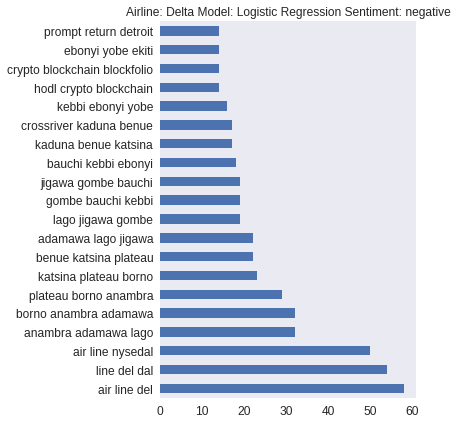

Index(['air line del', 'line del dal', 'air line nysedal',
       'anambra adamawa lago', 'borno anambra adamawa',
       'plateau borno anambra', 'katsina plateau borno',
       'benue katsina plateau', 'adamawa lago jigawa', 'lago jigawa gombe',
       'gombe bauchi kebbi', 'jigawa gombe bauchi', 'bauchi kebbi ebonyi',
       'kaduna benue katsina', 'crossriver kaduna benue', 'kebbi ebonyi yobe',
       'hodl crypto blockchain', 'crypto blockchain blockfolio',
       'ebonyi yobe ekiti', 'prompt return detroit'],
      dtype='object')


In [91]:
numGrams = 3
NumTopGrams = 20
airline = 'Delta'

target = df_senti['sentiment_predicted_lr'][df_senti.airline==airline]
model_name = 'Logistic Regression'
disp_top_gram_topics(numGrams, target, model_name, NumTopGrams, 'positive', airline)
disp_top_gram_topics(numGrams, target, model_name, NumTopGrams, 'negative', airline)

In [96]:
pulledTweets_df.columns

Index(['airline', 'date', 'text', 'clean_tweet', 'emoji_enc_tweet',
       'remstop_tweet', 'lemma_tweet', 'emojis', 'sentiment_predicted_nb',
       'sentiment_predicted_lr'],
      dtype='object')

## Look at the word frequencies of the positive and negative classified tweets.

In [110]:
def make_wordcloud(data, title, filename, mask):
    plt.figure(figsize=(7,7))
    im = WordCloud(max_words=300, mask=mask, background_color="white").generate(' '.join(i for i in data))
    plt.xticks([])
    plt.yticks([])
    plt.title(title, fontsize=14)
    im.to_file(filename)
    plt.imshow(im)

In [111]:
# twitter logo.
# used to print word cloud in twitter bird shape.
from PIL import Image
from wordcloud import WordCloud
wc_image_mask = np.array(Image.open('data/twitter.png'))
mask = wc_image_mask

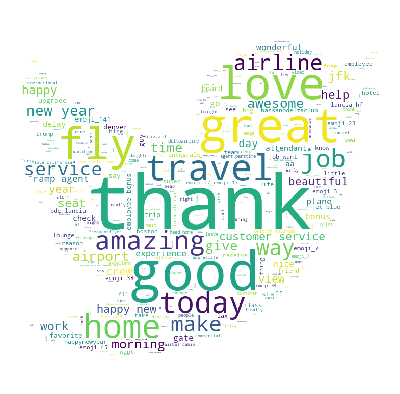

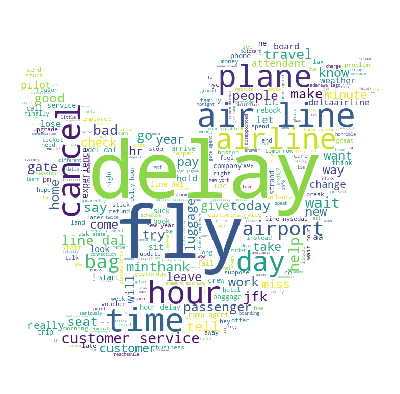

In [113]:
data = pulledTweets_df['lemma_tweet'][pulledTweets_df.sentiment_predicted_lr=='positive']
title = ""
filename = 'Pulled_Tweets_WordCld_pos_sent_lemmaused.png'
make_wordcloud(data, title, filename, mask)

# text with added elimination of stopwords.
data = pulledTweets_df['lemma_tweet'][pulledTweets_df.sentiment_predicted_lr=='negative']
title = ""
filename = 'Pulled_Tweets_WordCld_neg_sent_lemmaused.png'
make_wordcloud(data, title, filename, mask)

## Observations: 
Text classification can be very challenging, due to high levels of ambiguity.<br>
The the non structured casual language used by tweeters, can make interpretation difficult.<br>
Then we have the issue of acquiring training data, with labeled sentiment, to train statistical models.
Most often we have data with no labels, which makes supervised learning for this kind of data challenging.

This leads to my next exploration of unsupervised learning techniques, with Topic Modelling using LDA model.

## [Next Notebook: LDA Topic Modeling](5_TechnicalP_LDA.ipynb) 